### 座標とポテンシャルエネルギーを訓練データとして、エネルギー関数のパラメータ($\epsilon$と$\sigma$)を学習する

### 必要なパッケージを読み込む

In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using Distributions
using MDToolbox

### ポテンシャルエネルギー関数の定義

In [2]:
function compute_energy(coords1, coords2, epsilon, sigma)
    r = sqrt(sum((coords1 .- coords2).^2))
    U = epsilon * ((sigma/r)^12 - 2 * (sigma/r)^6)
    return U
end

compute_energy (generic function with 1 method)

In [3]:
function ChainRulesCore.rrule(::typeof(compute_energy), coords1, coords2, epsilon, sigma)
    dx = coords1 .- coords2
    r = sqrt(sum(dx.^2))
    U = epsilon * ((sigma / r)^12 - 2 * (sigma / r)^6) 

    function compute_energy_pullback(dU)
        dcoords1 = -12 * epsilon * ((sigma^12 / r^14) - (sigma^6 / r^8)) .* dx .* dU
        dcoords2 = - dcoords1
        depsilon = ((sigma / r)^12 - 2 * (sigma / r)^6) * dU
        dsigma = 12 * epsilon * (sigma^11 / r^12 - sigma^5 / r^6) * dU 
        return NoTangent(), dcoords1, dcoords2, depsilon, dsigma
    end
    return U, compute_energy_pullback
end

In [4]:
#二原子のトラジェクトリからFを計算
function compute_free_energy(coords1_trj, coords2_trj, beta, epsilon, sigma)
    N = size(coords1_trj, 1)
    U_array = [compute_energy(coords1, coords2, epsilon, sigma) for (coords1, coords2) in zip(coords1_trj, coords2_trj)]
    #F = (-1 / beta) * log((1 / N) * sum(exp.(-beta .* U_array)))
    F = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta .* U_array))
    return F
end

compute_free_energy (generic function with 1 method)

In [5]:
# exponential averaging
function compute_deltaF(coords_trj , beta, epsilon, sigma, U_array)
    N = size(coords_trj, 1)
    U_target_array = [compute_energy(coords1, coords2, epsilon, sigma) for (coords1, coords2) in coords_trj]
    deltaU = U_target_array .- U_array
    #@show deltaU
    #deltaF = (-1 / beta) * log((1 / N) * sum(exp.(-beta .* deltaU)))
    deltaF = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta .* deltaU))
    return deltaF
end

compute_deltaF (generic function with 1 method)

### MCMCの定義

In [6]:
#次のステップ候補点
function next_coords(coords1, coords2, delta_x = 1e-1)
    next_coords1 = coords1 .+ (rand(3) .- 0.5) .* delta_x
    next_coords2 = coords2 .+ (rand(3) .- 0.5) .* delta_x
    return next_coords1, next_coords2
end

next_coords (generic function with 2 methods)

In [7]:
#MCMC,メトロポリス法
function mcmc(coords1, coords2, epsilon, sigma, nstep = 100, beta = 1.0)
    coords1_trj = []
    coords2_trj = []
    alpha_trj = []
    push!(coords1_trj, coords1)
    push!(coords2_trj, coords2)
    
    for i in 1:nstep
        next_coords1, next_coords2 = next_coords(coords1, coords2) #候補点
        next_U = compute_energy(next_coords1, next_coords2, epsilon, sigma)
        current_U = compute_energy(coords1, coords2, epsilon, sigma)
        delta_U = next_U - current_U
        alpha = exp(-beta * delta_U) #相対確率
        
        #alpha>=1またはalpha<1のとき確率alphaで候補を受理
        if alpha > rand()
            coords1 .= next_coords1
            coords2 .= next_coords2
        end     
        push!(coords1_trj, copy(coords1))
        push!(coords2_trj, copy(coords2))
        push!(alpha_trj, alpha)
    end
    return coords1_trj, coords2_trj, alpha_trj
end

mcmc (generic function with 3 methods)

### ΔFを求める

In [19]:
kBT = 0.1
beta = 1.0/(kBT)
nstep = 1000000

K = 2

epsilon = Vector{Float64}(undef, K)
sigma = Vector{Float64}(undef, K)

epsilon[1] = 1.0
sigma[1] = 4.0

epsilon[2] = 1.2
sigma[2] = 4.2

trj1 = Vector{Any}(undef, K)
trj2 = Vector{Any}(undef, K)
for k = 1:K
    trj1[k], trj2[k], alpha = mcmc(rand(3), rand(3), epsilon[k], sigma[k], nstep, beta)
end

In [60]:
u_kl = Array{Any}(undef, (K, K))

for k = 1:K
    for l = 1:K
        u_kl[k, l] = map(x -> beta * compute_energy(x[1], x[2], epsilon[l], sigma[l]), zip(trj1[k], trj2[k]))
    end
end

In [82]:
f_k = mbar(u_kl)
(1 ./ beta) .* f_k

iteration = 1  delta = 1.414214e+00  tol = 1.000000e-08
free energies =  0.000000 -1.326778

iteration = 2  delta = 3.884048e-01  tol = 1.000000e-08
free energies =  0.000000 -1.829139

iteration = 3  delta = 1.097850e-01  tol = 1.000000e-08
free energies =  0.000000 -1.983086

iteration = 4  delta = 2.965533e-02  tol = 1.000000e-08
free energies =  0.000000 -2.025561

iteration = 5  delta = 7.856611e-03  tol = 1.000000e-08
free energies =  0.000000 -2.036877

iteration = 6  delta = 2.069443e-03  tol = 1.000000e-08
free energies =  0.000000 -2.039862

iteration = 7  delta = 5.442371e-04  tol = 1.000000e-08
free energies =  0.000000 -2.040647

iteration = 8  delta = 1.430677e-04  tol = 1.000000e-08
free energies =  0.000000 -2.040853

iteration = 9  delta = 3.760516e-05  tol = 1.000000e-08
free energies =  0.000000 -2.040908

iteration = 10  delta = 9.884179e-06  tol = 1.000000e-08
free energies =  0.000000 -2.040922

iteration =11  delta = 3.524266e-07  tol = 1.000000e-08
free energies

2-element Vector{Float64}:
  0.0
 -0.20409270006835328

In [83]:
# Sanity check
F = Vector{Any}(undef, K)
for k = 1:K
    F[k] = compute_free_energy(trj1[k], trj2[k], beta, epsilon[k], sigma[k])
end
@show F .- F[1]

F .- F[1] = [0.0, -0.20192129631088385]


2-element Vector{Float64}:
  0.0
 -0.20192129631088385

In [84]:
epsilon_target = 1.1
sigma_target = 4.1

trj1_target, trj2_target, alpha = mcmc(rand(3), rand(3), epsilon_target, sigma_target, nstep, beta);

In [85]:
@show F_target = compute_free_energy(trj1_target, trj2_target, beta, epsilon_target, sigma_target)

@show delta_F = F_target - F[1]

F_target = compute_free_energy(trj1_target, trj2_target, beta, epsilon_target, sigma_target) = -1.0599936672732722
delta_F = F_target - F[1] = -0.10171301151931722


-0.10171301151931722

In [128]:
# Sanity check
u_k = Vector{Any}(undef, K)

for k = 1:K
    u_k[k] = map(x -> beta * compute_energy(x[1], x[2], epsilon_target, sigma_target), zip(trj1[k], trj2[k]))
end

f_target = mbar_f(u_kl, f_k, u_k)
@show f_target
(1 ./ beta) * (f_target - f_k[1])

f_target = -1.0162637170553204


-0.10162637170553204

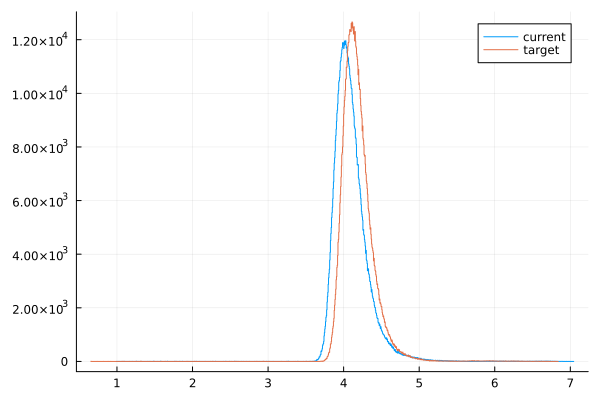

In [106]:
k = 1
r = [sqrt(sum((x - y).^2)) for (x, y) in zip(trj1[k], trj2[k])]
histogram(r,label="current")
r = [sqrt(sum((x - y).^2)) for (x, y) in zip(trj1_target, trj2_target)]
histogram!(r,label="target")

In [108]:
#パラメータ推定に用いる原子の軌跡と自由エネルギーの差
X_train = (trj1, trj2)
y_train = delta_F

-0.10171301151931722

### 勾配法で訓練してK(バネ定数)とR(平衡長)を推定

In [137]:
struct MBAR
    P::AbstractArray #P[1] = epsilon, P[2] = sigma
end

Flux.@functor MBAR (P,)

#(m::MBAR)(coords_trj) = compute_deltaF(coords_trj, beta, m.P[1], m.P[2], U_array)


In [138]:
function (m::MBAR)(X)
    for k = 1:K
        u_k[k] = map(x -> beta * compute_energy(x[1], x[2], m.P[1], m.P[2]), zip(X[1][k], X[2][k]))
    end
    f_target = mbar_f(u_kl, f_k, u_k)
    delta_F = (1 ./ beta) * (f_target - f_k[1])
    return delta_F
end

In [141]:
# Lossの定義
m = MBAR([epsilon[1], sigma[1]])
loss(X, y) = Flux.Losses.mse(m(X), y)
loss(X_train, y_train)

0.010345536712328757

In [142]:
# DataやOptimizerの定義
#train_loader = Flux.Data.DataLoader(X_train, batchsize=10, shuffle=true)
ps = Flux.params(m)
opt = ADAM(1e-2)

Adam(0.01, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [143]:
# コールバック関数の定義
function print_callback(epoch, loss, ps)
    println("Epoch: $epoch, loss: $loss")
    println("param: $(ps[1])")
end

print_callback (generic function with 1 method)

In [144]:
# 訓練
loss_train = []

for epoch in 1:10
    gs = gradient(() -> loss(X_train, y_train), ps)
    Flux.Optimise.update!(opt, ps, gs)
    
    L = loss(X_train, y_train)
    push!(loss_train, L)
    print_callback(epoch, L, ps)
end

LoadError: Mutating arrays is not supported -- called setindex!(Vector{Any}, ...)
This error occurs when you ask Zygote to differentiate operations that change
the elements of arrays in place (e.g. setting values with x .= ...)

Possible fixes:
- avoid mutating operations (preferred)
- or read the documentation and solutions for this error
  https://fluxml.ai/Zygote.jl/latest/limitations


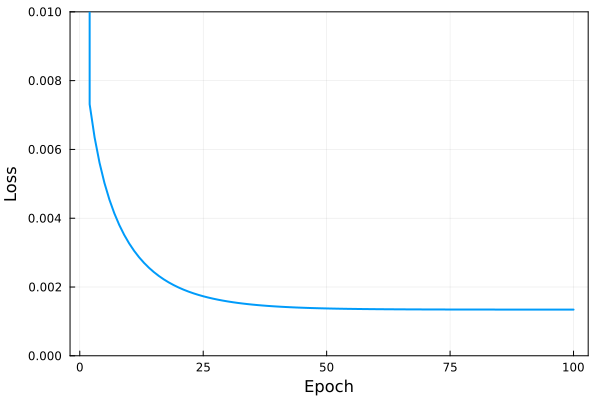

In [350]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2, ylims=(0.0, 0.01))
ylabel!("Loss")
xlabel!("Epoch")

In [351]:
println("Initial epsilon:   ", epsilon)
println("Estimated epsilon: ", m.P[1])
println("Target epsilon:    ", epsilon_target)
println()
println("Initial sigma:   ", sigma)
println("Estimated sigma: ", m.P[2])
println("Target sigma:    ", sigma_target)

Initial epsilon:   1.0
Estimated epsilon: 1.065586612223772
Target epsilon:    1.1

Initial sigma:   4.0
Estimated sigma: 4.045585787192477
Target sigma:    4.1


In [352]:
# Sanity check
@show delta_F

@show compute_deltaF(X_train, beta, m.P[1], m.P[2], U_array)

delta_F = -0.10160552788901855
compute_deltaF(X_train, beta, m.P[1], m.P[2], U_array) = -0.06495955323038878


-0.06495955323038878